<a href="https://colab.research.google.com/github/AggelosRDio/MscMachineLearning/blob/master/ML7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 7 - SVM - Bayes

After recent natural disasters, the government decided to improve the prevention and evacuation system with the help of posts from X (Twitter). More specifically, the system will examine posts and, in case it determines that a natural disaster (target = 1) is in progress, it will send an appropriate message via 112.

## Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Question 1

Download the training/testing datasets train.csv and split the dataset into train-test (90-10%) using the options stratify and random_state = 0. https://www.kaggle.com/competitions/nlp-getting-started

Then, create a bar plot showing the number of target values in the train and test sets respectively. Is the dataset balanced?

### CSV Reading & Data Split

In [2]:
df = pd.read_csv('train.csv')

df_train, df_test = train_test_split(df, test_size=0.1, stratify=df['target'], random_state=0)

### Bar Plot & Distribution

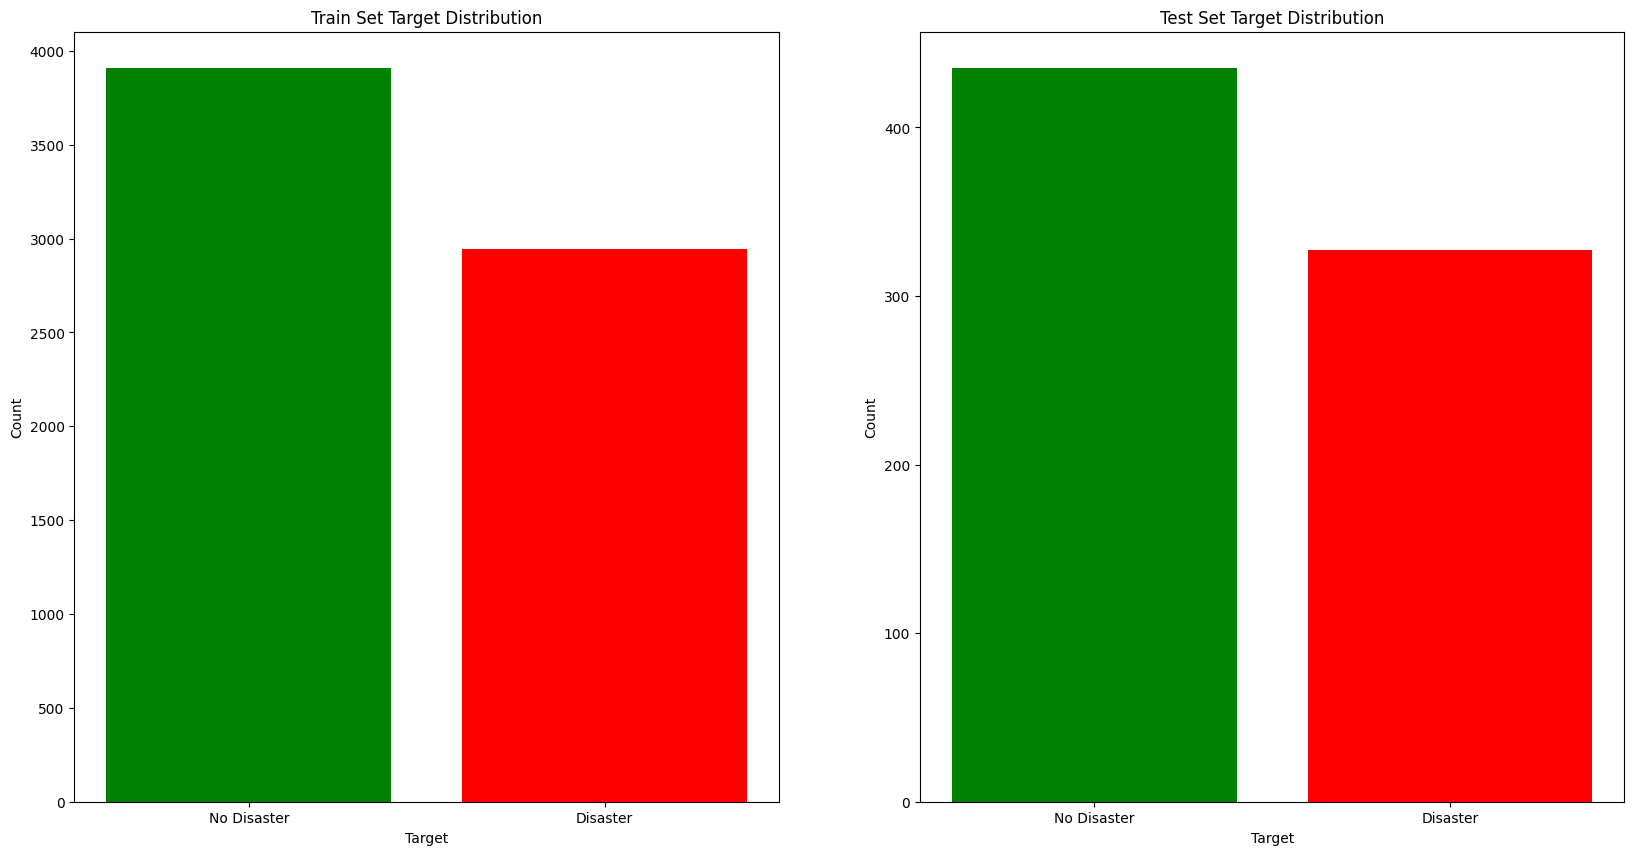

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].bar(['No Disaster', 'Disaster'], df_train['target'].value_counts().sort_index().values, color=['green', 'red'])
axes[0].set_title('Train Set Target Distribution')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Target')

axes[1].bar(['No Disaster', 'Disaster'], df_test['target'].value_counts().sort_index().values, color=['green', 'red'])
axes[1].set_title('Test Set Target Distribution')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Target')

plt.show()

The dataset is not balanced as we see a lot more non-disaster values (target: 0) than distaster (target 1)

## Question 2

1. Preprocess the train/test data as follows:

    a. Remove the features id, location.

    b. Fill missing values with the keyword "null".

    c. Merge the columns keyword and text as:
    - `df['inputs'] = df['keyword'] + ' ' + df['text']`


In [4]:
df_train = df_train.drop(['id', 'location'], axis=1)
df_test = df_test.drop(['id', 'location'], axis=1)

df_train['keyword'] = df_train['keyword'].fillna('null')
df_train['text'] = df_train['text'].fillna('null')

df_test['keyword'] = df_test['keyword'].fillna('null')
df_test['text'] = df_test['text'].fillna('null')

## Question 3

Process the tweet texts (inputs) in train and test, aiming to remove all unnecessary information (e.g. symbols, emojis, etc.). Use the ready-made implemented functions that you will find in the following repository: https://github.com/Deffro/text-preprocessing-techniques/tree/master?tab=readme-ov-file#0-remove-unicode-strings-and-noise

Briefly describe (in 1 line) each technique you used and justify the reason you chose these specific techniques.

In [5]:
df_train['inputs'] = df_train['keyword'] + ' ' + df_train['text']
df_test['inputs'] = df_test['keyword'] + ' ' + df_test['text']

In [6]:
!git clone https://github.com/Deffro/text-preprocessing-techniques.git

fatal: destination path 'text-preprocessing-techniques' already exists and is not an empty directory.


In [7]:
!pip install nltk

In [8]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
import sys
import os

sys.path.append('text-preprocessing-techniques')
os.chdir("/content/text-preprocessing-techniques")

In [10]:
import re
import string
from techniques import replaceURL, removeEmoticons



def removePunctuation(input):
  result = input.translate(str.maketrans('', '', string.punctuation))
  return result

def preprocess(input):
  result = input.lower()
  result = replaceURL(input)
  result = removeEmoticons(result)
  result = removePunctuation(result)

  return result


We are preprocessing as follows:

1. lower text case for normalization
2. replace URLs because they have no semantic value
3. remove emoticons due to being hard to vectorize
4. remove punctuation to reduce noise

In [11]:
df_train['inputs'] = df_train['inputs'].apply(preprocess)
df_test['inputs'] = df_test['inputs'].apply(preprocess)

df_train[: 100]

,keyword,text,target,inputs
6669,threat,Meek Mill responds to DrakeÛªs OVO Fest set w...,1,threat Meek Mill responds to DrakeÛªs OVO Fes...
3940,flood,survived the plague\nfloated the flood\njust p...,0,flood survived the plague\nfloated the flood\n...
7217,weapons,#Kick Hendrixonfire @'=BLACKCATS= | BIG NOOB ...,0,weapons Kick Hendrixonfire BLACKCATS BIG NOO...
2234,deluge,Vince McMahon once again a billionaire: I reme...,0,deluge Vince McMahon once again a billionaire ...
4233,hazardous,Is it possible to sneak into a hospital so I c...,0,hazardous Is it possible to sneak into a hospi...
...,...,...,...,...
1333,burning%20buildings,the mv should just be them strutting like they...,1,burning20buildings the mv should just be them ...
4686,landslide,@toddstarnes Enjoy the impending landslide Tod...,0,landslide toddstarnes Enjoy the impending land...
5545,rainstorm,Rainstorm downtown Gloucester\n#gloucester #ca...,1,rainstorm Rainstorm downtown Gloucester\nglouc...
915,bloody,'I came to kill Indians...for FUN': Video of s...,1,bloody I came to kill Indiansfor FUN Video of ...


## Question 4

Split the data into inputs, targets (NumPy arrays).

In [12]:
x_train = df_train['inputs'].values
y_train = df_train['target'].values

x_test = df_test['inputs'].values
y_test = df_test['target'].values

## Question 5

Transform the inputs as follows: For each post, compute the TF-IDF of each word. Use the TfidfVectorizer class from scikit-learn: https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

You will need to apply fit_transform on the train set and only transform on the test set.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
x_train_vectorized = vectorizer.fit_transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

## Question 6

Train an SVM classifier with a linear kernel (LinearSVC) https://scikit-learn.org/dev/modules/generated/sklearn.svm.LinearSVC.html

on the train set and measure for both the train and test sets: Accuracy, F1, Precision, Recall.

Which metric is the most important? Justify your answer.

In [14]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

linear_svc = LinearSVC()
linear_svc.fit(x_train_vectorized, y_train)

y_train_pred = linear_svc.predict(x_train_vectorized)
y_test_pred = linear_svc.predict(x_test_vectorized)

train_metrics = {
    'Accuracy': accuracy_score(y_train, y_train_pred),
    'F1': f1_score(y_train, y_train_pred),
    'Precision': precision_score(y_train, y_train_pred),
    'Recall': recall_score(y_train, y_train_pred)
}

test_metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'F1': f1_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred)
}

print("Train Metrics: ")
print(train_metrics)
print()
print("Test Metrics: ")
print(test_metrics)


Train Metrics: 
{'Accuracy': 0.9708071814333674, 'F1': 0.9654815326199516, 'Precision': 0.9814035087719298, 'Recall': 0.9500679347826086}

Test Metrics: 
{'Accuracy': 0.7979002624671916, 'F1': 0.7555555555555555, 'Precision': 0.7854785478547854, 'Recall': 0.72782874617737}


Because our goal is disaster prediction, **Recall** is the most important metric, because missing real disasters is far more dangerous than false positives. Recall ensures we catch most disasters.

## Question 7

Apply a PCA transformation to the data, retaining 95% of the useful information (note: not the components!). Then, train LinearSVC and SVC with RBF kernel: https://scikit-learn.org/dev/modules/generated/sklearn.svm.SVC.html

and compare their performance.

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=0)
x_train_pca = pca.fit_transform(x_train_vectorized.toarray())
x_test_pca = pca.transform(x_test_vectorized.toarray())

### Train Linear SVC

In [16]:
linear_svc_pca = LinearSVC()
linear_svc_pca.fit(x_train_pca, y_train)

y_test_pred_linear_pca = linear_svc_pca.predict(x_test_pca)

linear_svc_pca_metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred_linear_pca),
    'F1': f1_score(y_test, y_test_pred_linear_pca),
    'Precision': precision_score(y_test, y_test_pred_linear_pca),
    'Recall': recall_score(y_test, y_test_pred_linear_pca)
}

print("Linear SVC with PCA Metrics:")
print(linear_svc_pca_metrics)

Linear SVC with PCA Metrics:
{'Accuracy': 0.8097112860892388, 'F1': 0.7702060221870047, 'Precision': 0.7993421052631579, 'Recall': 0.7431192660550459}


### Train SVC with RBF Kernel

In [17]:
from sklearn.svm import SVC

svc_rbf = SVC(kernel='rbf', random_state=0)
svc_rbf.fit(x_train_pca, y_train)
y_test_pred_rbf = svc_rbf.predict(x_test_pca)

svc_rbf_metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred_rbf),
    'F1': f1_score(y_test, y_test_pred_rbf),
    'Precision': precision_score(y_test, y_test_pred_rbf),
    'Recall': recall_score(y_test, y_test_pred_rbf)
}

print("SVC with RBF Kernel Metrics:")
print(svc_rbf_metrics)

SVC with RBF Kernel Metrics:
{'Accuracy': 0.8162729658792651, 'F1': 0.7763578274760383, 'Precision': 0.8127090301003345, 'Recall': 0.7431192660550459}


## Question 8

What is the value of the parameter (Gamma) used by default with scale, and what is the value with auto? Change the parameter to auto and retrain the SVC. Finally, create a bar plot comparing the metrics accuracy, F1, precision, recall of the four trained models.

In [18]:
n_features = x_train_pca.shape[1]
variance = x_train_pca.var()

gamma_scale = 1 / (n_features * variance)
print(f"Gamma Scale: {gamma_scale}")

gamma_auto = 1 / n_features
print(f"Gamma Auto: {gamma_auto}")


Gamma Scale: 1.0641067585219892
Gamma Auto: 0.00023934897079942556


In [19]:
n_features

4178

In [20]:
svc_rbf_auto = SVC(kernel='rbf', gamma='auto', random_state=0)
svc_rbf_auto.fit(x_train_pca, y_train)
y_test_pred_rbf_auto = svc_rbf_auto.predict(x_test_pca)

svc_rbf_auto_metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred_rbf_auto),
    'F1': f1_score(y_test, y_test_pred_rbf_auto),
    'Precision': precision_score(y_test, y_test_pred_rbf_auto),
    'Recall': recall_score(y_test, y_test_pred_rbf_auto)
}

print("SVC with RBF Kernel Metrics:")
print(svc_rbf_auto_metrics)

SVC with RBF Kernel Metrics:
{'Accuracy': 0.5708661417322834, 'F1': 0.0, 'Precision': 0.0, 'Recall': 0.0}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Comparison Plot

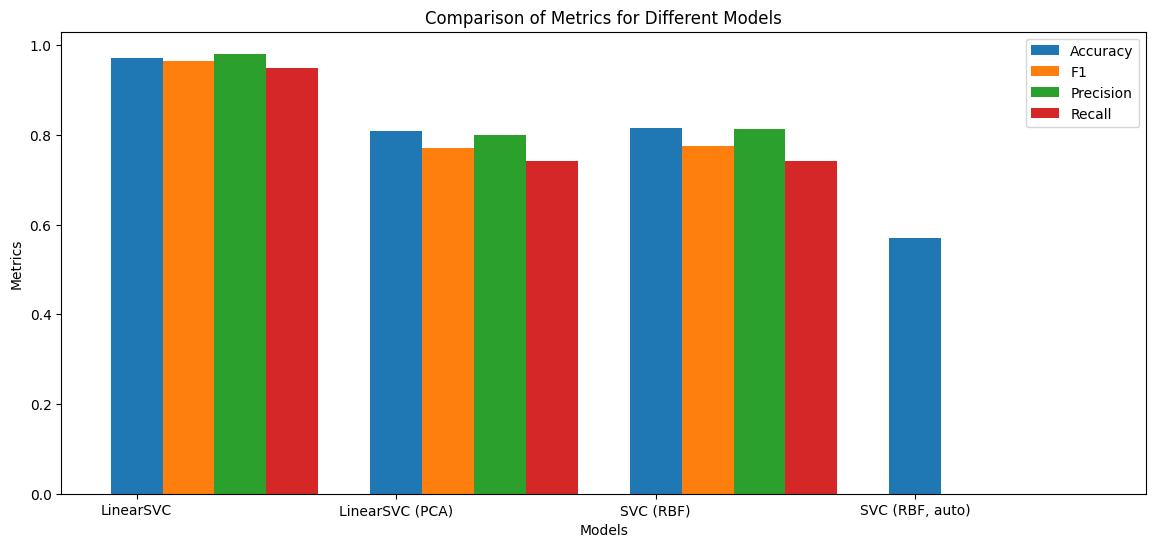

In [21]:
models = ['LinearSVC', 'LinearSVC (PCA)', 'SVC (RBF)', 'SVC (RBF, auto)']
metrics = ['Accuracy', 'F1', 'Precision', 'Recall']

comparison_data = {
    'Accuracy': [train_metrics['Accuracy'], linear_svc_pca_metrics['Accuracy'], svc_rbf_metrics['Accuracy'], svc_rbf_auto_metrics['Accuracy']],
    'F1': [train_metrics['F1'], linear_svc_pca_metrics['F1'], svc_rbf_metrics['F1'], svc_rbf_auto_metrics['F1']],
    'Precision': [train_metrics['Precision'], linear_svc_pca_metrics['Precision'], svc_rbf_metrics['Precision'], svc_rbf_auto_metrics['Precision']],
    'Recall': [train_metrics['Recall'], linear_svc_pca_metrics['Recall'], svc_rbf_metrics['Recall'], svc_rbf_auto_metrics['Recall']]
}

fig, axis = plt.subplots(figsize=(14, 6))
x = np.arange(len(models))
width = 0.2

for i, metric in enumerate(metrics):
    axis.bar(x + i * width, comparison_data[metric], width, label=metric)

axis.set_xlabel('Models')
axis.set_ylabel('Metrics')
axis.set_title('Comparison of Metrics for Different Models')
axis.set_xticks(x)
axis.set_xticklabels(models)
axis.legend()

plt.show()


PCA kept 4178 features to capture 95% of variance. Given the huge number the auto gamma 1 / n_features is approximately equal to 0.00024 which is too low for RBF kernel.

The model essentially becomes a linear classifier and can't capture non-linear patterns and it likely predicts majority class.

As a result of the above recall is 0 because it never predicts 1s, precision is undefined and defaults to 0 and f1 is 0 as a result of this as well.

## Question 9

Repeat question 6 (before applying the PCA transformation) using Gaussian Naive Bayes: https://scikit-learn.org/dev/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [22]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(x_train_vectorized.toarray(), y_train)

y_train_pred = gnb.predict(x_train_vectorized.toarray())
y_test_pred = gnb.predict(x_test_vectorized.toarray())

train_metrics = {
    'Accuracy': accuracy_score(y_train, y_train_pred),
    'F1': f1_score(y_train, y_train_pred),
    'Precision': precision_score(y_train, y_train_pred),
    'Recall': recall_score(y_train, y_train_pred)
}

test_metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'F1': f1_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred)
}

print("Train Metrics: ")
print(train_metrics)
print()
print("Test Metrics: ")
print(test_metrics)

Train Metrics: 
{'Accuracy': 0.9213253539629251, 'F1': 0.9161350552357242, 'Precision': 0.8452483491243181, 'Recall': 1.0}

Test Metrics: 
{'Accuracy': 0.6286089238845144, 'F1': 0.6466916354556804, 'Precision': 0.5464135021097046, 'Recall': 0.7920489296636085}
